# Clustering


Clustering is unsupervised learning.  That means we do not have the labels to
learn from.  We aim to learn both the labels for each point and some way of
characterizing the classes at the same time.  

Computationally, this is a harder problem.  Mathematically, we can
typically solve problems when we have a number of equations equal to or greater
than the number of unknowns.  For $N$ data points ind $d$ dimensions and $K$ clusters, we have $N$
equations and $N + K*d$ unknowns. This means we have a harder problem to solve.

For today, we'll see K-means clustering which is defined by $K$ a number of
clusters and a mean (center) for each one.  There are other K-centers algorithms
for other types of centers.

Clustering is a stochastic (random) algorithm, so it can be a little harder to debug the models and measure performance.  For this reason, we are going to lootk a little more closely at what it actuall *does* than we have with classification or regression.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
import seaborn as sns
from sklearn import datasets
from sklearn.cluster import KMeans
import string
import pandas as pd

## How does Kmeans work?

We will start with some synthetics data and then see how the clustering works.

````{margin}
```{note}
This code should be fairly readable, but is not strictly required.
One tricky part is [`zip`](https://docs.python.org/3.9/library/functions.html#zip) which is a builtin fuction for iteratinv over groups of things together.

And [`itertools`](https://docs.python.org/3/library/itertools.html) is a core library for related more iterating.
```
````

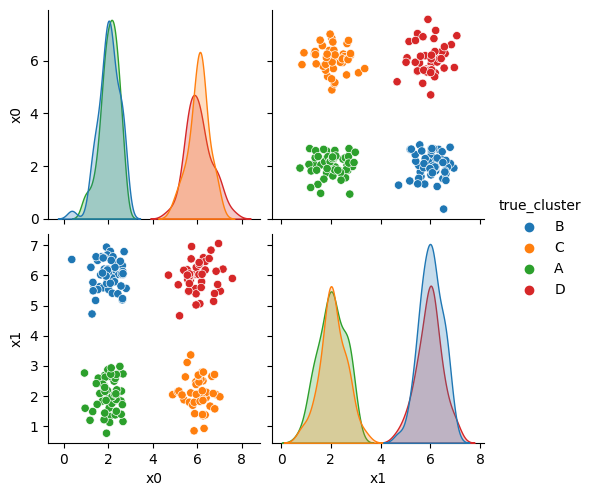

In [2]:
C = 4
N = 200
offset = 2
spacing = 2

# choose the first C uppcase letters
classes = list(string.ascii_uppercase[:C])
# get the number of grid locations needed
G = int(np.ceil(np.sqrt(C)))
# get the locations for each axis
grid_locs = a = np.linspace(offset,offset+G*spacing,G)
# compute grid (i,j) for each combination of values above & keep C values
means = [(i,j) for i, j in it.product(grid_locs,grid_locs)][:C]
# store in dictionary with class labels
mu = {c: i for c, i in zip(classes,means)}
# random variances
sigma = {c: i*.5 for c, i in zip(classes,np.random.random(4))}

#randomly choose a class for each point, with equal probability
clusters_true = np.random.choice(classes,N)
# draw a randome point according to the means from above for each point
data = [np.random.multivariate_normal(mu[c],.25*np.eye(2)) for c in clusters_true]
# rounding to make display neater later
df = pd.DataFrame(data = data,columns = ['x' + str(i) for i in range(2)]).round(2)

# store in dataFram
df['true_cluster'] = clusters_true

sns.pairplot(data =df, hue='true_cluster')

In [3]:
df.head()

,x0,x1,true_cluster
0,2.15,5.89,B
1,5.93,2.47,C
2,2.56,6.03,B
3,2.07,1.32,A
4,2.14,5.82,B


## Kmeans


Next, we'll pick 4 random points to be the starting points as the means.

In [4]:
K = 4
mu0 = df.sample(n=K).values
mu0

array([[1.84, 2.68, 'A'],
       [1.66, 2.08, 'A'],
       [2.15, 5.89, 'B'],
       [1.95, 5.79, 'B']], dtype=object)

Now, we will compute, fo each sample which of those four points it is closest to
first by taking the difference, squaring it, then summing along each row.

In [5]:
[((df-mu_i)**2).sum(axis=1) for mu_i in mu0]

TypeError: unsupported operand type(s) for -: 'str' and 'str'

This gives us a list of 4 data DataFrames, one for each mean (mu), with one row
for each point in the dataset with the distance from that point to the
corresponding mean. We can stack these into one DataFrame.

In [6]:
pd.concat([((df-mu_i)**2).sum(axis=1) for mu_i in mu0],axis=1).head()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

Now we have one row per sample and one column per mean, with with the distance from that point to the mean. What we want is to calculate the assignment, which
mean is closest, for each point.  Using `idxmin` with `axis=1` we take the
minimum across each row and returns the index (location) of that minimum.

In [7]:
pd.concat([((df-mu_i)**2).sum(axis=1) for mu_i in mu0],axis=1).idxmin(axis=1).head()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

We'll save all of this in a column named `'0'`. Since it is our 0th iteration.

In [8]:
df['0'] = pd.concat([((df-mu_i)**2).sum(axis=1) for mu_i in mu0],axis=1).idxmin(axis=1)

df.head()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

Here, we'll set up some helper code.
````{margin}
```{admonition} Further Reading
For more on [color palettes](https://seaborn.pydata.org/generated/seaborn.color_palette.html) see the seaborn docs
```
````

In [9]:
data_cols = ['x0','x1']
def mu_to_df(mu,i):
    mu_df = pd.DataFrame(mu,columns=data_cols)
    mu_df['iteration'] = str(i)
    mu_df['class'] = ['M'+str(i) for i in range(K)]
    mu_df['type'] = 'mu'
    return mu_df

# color maps, we select every other value from this palette that has 8 values & is paird
cmap_pt = sns.color_palette('tab20',8)[1::2] # starting from 1
cmap_mu = sns.color_palette('tab20',8)[0::2] # starting form 0

Now we can plot the data, save the axis, and plot the means on top of that.
Seaborn plotting functions return an axis, by saving that to a variable, we
can pass it to the `ax` parameter of another plotting function so that both
plotting functions go on the same figure.

In [10]:
sfig = sns.scatterplot(data=df,x='x0',y='x1', hue='0',
                       palette =cmap_pt,legend=False)
mu_df = mu_to_df(mu0,0)
sns.scatterplot(data=mu_df, x='x0',y='x1',hue='class',
                palette=cmap_mu,legend=False, ax=sfig)

ValueError: Could not interpret value `0` for parameter `hue`

We see that each point is assigned to the lighter shade of its matching mean.
These points are the one that is closest to each point, but they're not the
centers of the point clouds.
Now, we can compute new means of the points assigned to each cluster, using
groupby.

In [11]:
mu1 = df.groupby('0')[data_cols].mean().values
mu1

KeyError: '0'

We can plot these again, the same data, but with the new means.

In [12]:
sfig = sns.scatterplot(data=df,x='x0',y='x1', hue='0',
                       palette =cmap_pt,legend=False)
mu_df = mu_to_df(mu1,0)
sns.scatterplot(data=mu_df, x='x0',y='x1',hue='class',
                palette=cmap_mu,legend=False, ax=sfig)

ValueError: Could not interpret value `0` for parameter `hue`

We see that now the means are in the center of each cluster, but that there are
now points in one color that are assigned to other clusters.

So, again we can update the assignments.

In [13]:
df['1'] = pd.concat([((df[data_cols]-mu_i)**2).sum(axis=1) for mu_i in mu1],axis=1).idxmin(axis=1)

NameError: name 'mu1' is not defined

And plot again.

In [14]:
sfig = sns.scatterplot(data=df,x='x0',y='x1', hue='0',
                       palette =cmap_pt,legend=False)
mu_df = mu_to_df(mu,0)
sns.scatterplot(data=mu_df, x='x0',y='x1',hue='class',
                palette=cmap_mu,legend=False, ax=sfig)

ValueError: Could not interpret value `0` for parameter `hue`

If we keep going back and forth like this, eventually, the assignment step will
not change any assignments. We call this condition convergence. We can
implement the algorithm with a while loop.

```{admonition} Correction
In the following I swapped the order of the mean update and assignment steps.  
My previous version had a different *initialization* (the above part) so it
was okay for the steps to be in the other order.
```

In [15]:
i =1
mu_list = [mu_to_df(mu0,i), mu_to_df(mu1,i)]
cur_old = str(i-1)
cur_new = str(i)
while sum(df[cur_old] !=df[cur_new]) >0:
    cur_old = cur_new
    i +=1
    cur_new = str(i)
        #     update the means and plot with current generating assignments
    mu = df.groupby(cur_old)[data_cols].mean().values
    mu_df = mu_to_df(mu,i)
    mu_list.append(mu_df)

    fig = plt.figure()
    sfig = sns.scatterplot(data =df,x='x0',y='x1',hue=cur_old,palette=cmap_pt,legend=False)
    sns.scatterplot(data =mu_df,x='x0',y='x1',hue='class',palette=cmap_mu,ax=sfig,legend=False)


    #     update the assigments and plot with the associated means
    df[cur_new] = pd.concat([((df[data_cols]-mu_i)**2).sum(axis=1) for mu_i in mu],axis=1).idxmin(axis=1)
    fig = plt.figure()
    sfig = sns.scatterplot(data =df,x='x0',y='x1',hue=cur_new,palette=cmap_pt,legend=False)
    sns.scatterplot(data =mu_df,x='x0',y='x1',hue='class',palette=cmap_mu,ax=sfig,legend=False)


n_iter = i

ValueError: Shape of passed values is (4, 3), indices imply (4, 2)

This algorithm is random.  So each time we run it, it looks a little different.

![scatterplot of gaussian data in 4 clusters running kmeans](../img/demo_kmeans1.gif)

![scatterplot of gaussian data in 4 clusters running kmeans](../img/demo_kmeans2.gif)

![scatterplot of gaussian data in 4 clusters running kmeans](../img/demo_kmeans3.gif)

![scatterplot of gaussian data in 4 clusters running kmeans](../img/demo_kmeans4.gif)


## Questions After class

### Are there any better way to optimize than run multiple times?

Not totally, the Kmeans ++ algorithm for initialization will help, but sometimes just multiple times is all we have because there is so much more unknown than known.


### How do we use sklearn to cluster data?

We will see that Wednesday, but the short answer is that there is a an estimator object for the clustering model and then we use the `fit` method